In [46]:
import jsonpatch
import pyhf
import pyhf.simplemodels
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [58]:
def plot_results(mutests, tests, test_size = 0.05):
    cls_obs = np.array([test[0] for test in tests]).flatten()
    cls_exp = [np.array([test[1][i] for test in tests]).flatten() for i in range(5)]

    plt.plot(mutests,cls_obs, c = 'k')
    for i,c in zip(range(5),['grey','grey','grey','grey','grey']):
        plt.plot(mutests, cls_exp[i], c = c)
    plt.plot(testmus,[test_size]*len(testmus), c = 'r')
    plt.ylim(0,1)

def invert_interval(testmus, cls_obs, cls_exp, test_size = 0.05):
    point05cross = {'exp':[],'obs':None}
    for cls_exp_sigma in cls_exp:
        yvals = cls_exp_sigma
        point05cross['exp'].append(np.interp(test_size,
                                             list(reversed(yvals)),
                                             list(reversed(testmus))))
        
    yvals = cls_obs
    point05cross['obs'] = np.interp(test_size,
                                    list(reversed(yvals)),
                                    list(reversed(testmus)))
    return point05cross

In [85]:
data = [51, 62.]


original = pyhf.simplemodels.hepdata_like([5.,6.],[50.,65.],[5.,3.])

/home/jovyan/pyhf/tensor/numpy_backend.py:126: RuntimeWarning: divide by zero encountered in log
  return np.exp(n*np.log(lam)-lam-gammaln(n+1.))
/home/jovyan/pyhf/tensor/numpy_backend.py:82: RuntimeWarning: divide by zero encountered in log
  return np.log(tensor_in)


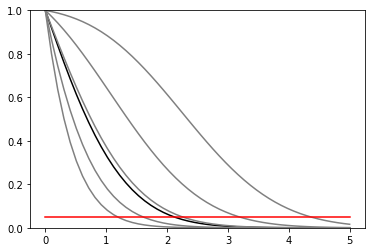

In [86]:
testmus = np.linspace(0,5)
results = [
    pyhf.runOnePoint(mu, data + original.config.auxdata, original, original.config.suggested_init(), original.config.suggested_bounds())[-2:]
    for mu in testmus
]
plot_results(testmus,results,test_size = 0.05)

In [88]:
patch = jsonpatch.JsonPatch([
    {'op': 'replace', 'path': '/channels/0/samples/0/data', 'value': [20.,10.]},
])

In [89]:
recast = pyhf.hfpdf(patch.apply(p.spec))
recast.spec

{'channels': [{'name': 'singlechannel',
   'samples': [{'name': 'signal',
     'data': [20.0, 10.0],
     'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None}]},
    {'name': 'background',
     'data': [50.0, 65.0],
     'modifiers': [{'name': 'uncorr_bkguncrt',
       'type': 'shapesys',
       'data': [5.0, 3.0]}]}]}]}

/home/jovyan/pyhf/tensor/numpy_backend.py:82: RuntimeWarning: divide by zero encountered in log
  return np.log(tensor_in)
/home/jovyan/pyhf/tensor/numpy_backend.py:126: RuntimeWarning: divide by zero encountered in log
  return np.exp(n*np.log(lam)-lam-gammaln(n+1.))


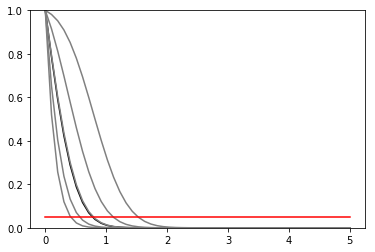

In [90]:
testmus = np.linspace(0,5)
results = [
    pyhf.runOnePoint(mu, data + recast.config.auxdata, recast, recast.config.suggested_init(), recast.config.suggested_bounds())[-2:]
    for mu in testmus
]
plot_results(testmus,results,test_size = 0.05)